# Quantum Machine Learning

Eigenvalue problem

In [52]:
import os
import qiskit

from qiskit import *

from qiskit_aer import Aer
from qiskit_aer import *

from qiskit.visualization import *

# SciPy minimizer routine
from scipy.optimize import minimize
import time
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2

from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit


In [53]:
%run ../src/harmonic-oscillator.py

[[ 5.000000e-01-1.2246468e-16j -5.000000e-01+6.1232340e-17j
   5.000000e-01+0.0000000e+00j -5.000000e-01-6.1232340e-17j]
 [-5.000000e-01+6.1232340e-17j  3.061617e-17+5.0000000e-01j
   5.000000e-01+0.0000000e+00j  3.061617e-17-5.0000000e-01j]
 [ 5.000000e-01+0.0000000e+00j  5.000000e-01+0.0000000e+00j
   5.000000e-01+0.0000000e+00j  5.000000e-01+0.0000000e+00j]
 [-5.000000e-01-6.1232340e-17j  3.061617e-17-5.0000000e-01j
   5.000000e-01+0.0000000e+00j  3.061617e-17+5.0000000e-01j]]
[[ 0.6875+0.00000000e+00j -0.125 -1.38777878e-17j  0.0625+3.06161700e-17j
  -0.125 -4.51028104e-17j]
 [-0.125 +1.38777878e-17j  0.3125+0.00000000e+00j -0.125 -1.38777878e-17j
   0.0625+3.06161700e-17j]
 [ 0.0625-3.06161700e-17j -0.125 +1.38777878e-17j  0.1875+0.00000000e+00j
  -0.125 -1.38777878e-17j]
 [-0.125 +4.51028104e-17j  0.0625-3.06161700e-17j -0.125 +1.38777878e-17j
   0.3125+0.00000000e+00j]]
(['II', 'XI', 'ZI', 'IX', 'XX', 'IZ', 'ZZ'], [0.375, -0.125, 0.0625, 0.0625, -0.125, 0.125, 0.125], [array([[1

# Step 1. Map classical inputs to a quantum problem
Get the decompositin of the Hamiltonian

In [54]:
n_qubits = 5
obs, coeffs , mat = decompose_ham_to_pauli(getHamiltonian(n_qubits))

In [55]:
# obs

In [56]:
opList = [(a, b) for a, b in zip(obs, coeffs)]

In [57]:
# opList

In [58]:
hamiltonian = SparsePauliOp.from_list(opList)

In [59]:
# hamiltonian

In [60]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

# 2. Callback methods for better post processing

We can introcude methods that will be executed at each iteration in QuantumComputer

In [62]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


#### Initialize the callback_dict dictionary

In [63]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [64]:
# num_params = ansatz.num_parameters
# print(num_params)
# x0 = 2 * np.pi * np.random.random(num_params)

# 3. Running In Simulator 

In [65]:
# ansatz_sim=transpile(ansatz)
# ansatz_sim.draw(output="mpl")

ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")


In [ ]:
ansatz_sim=transpile(ansatz)

In [66]:
from qiskit.primitives import Estimator

backend = Aer.get_backend('qasm_simulator')

# x0 is the initial values of the parameters
x0 = np.ones(ansatz.num_parameters) * np.pi/4
print(x0.shape)


estimator = Estimator()
estimator.options.shots=4096

callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options={"maxiter":1000}
)



(40,)


In [67]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.21163974605435
       x: [ 2.082e+00  2.867e-01 ...  9.982e-02 -4.908e-01]
    nfev: 400
   maxcv: 0.0

# 4. Post Processing

In [68]:
all(callback_dict["prev_vector"] == res.x)
callback_dict["iters"] == res.nfev

True

In [69]:
import matplotlib.pyplot as plt

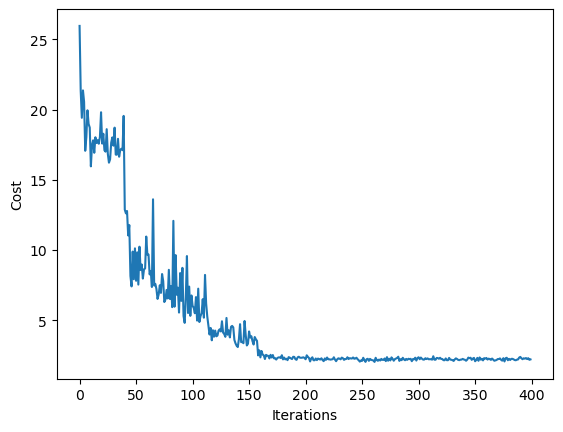

In [70]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()